# NFL Score Predictions
### Predict scores of NFL games based on FiveThirtyEight's data set.
_________________________________________________________________

Import libraries, read in data set, and remove bad values.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

# Read in the data set
games = pd.read_csv('../data/nfl_games.csv')
# Remove rows with NaN values
games = games.dropna()

games.head(3)

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1
0,1920-09-26,1920,0,0,RII,STP,1503.947,1300.0,0.824651,48,0,1.0
1,1920-10-03,1920,0,0,AKR,WHE,1503.420,1300.0,0.824212,43,0,1.0
2,1920-10-03,1920,0,0,RCH,ABU,1503.420,1300.0,0.824212,10,0,1.0


## Exploratory Data Analysis
___

### 1. Explore Correlation Between Dates and Score

In [116]:
games["totalScore"] = games["score1"] + games["score2"]

# Put date column in YYYYMMDD format, create month and day column
games["date"] = pd.to_datetime(games["date"]).dt.strftime("%Y%m%d").astype(int)
games["month"] = [calendar.month_abbr[int((i%10000)/100)] for i in games["date"]]
games["day"] = [int(i%100) for i in games["date"]]
games.head(3)

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,totalScore,month,day
0,19200926,1920,0,0,RII,STP,1503.947,1300.0,0.824651,48,0,1.0,48,Sep,26
1,19201003,1920,0,0,AKR,WHE,1503.420,1300.0,0.824212,43,0,1.0,43,Oct,3
2,19201003,1920,0,0,RCH,ABU,1503.420,1300.0,0.824212,10,0,1.0,10,Oct,3


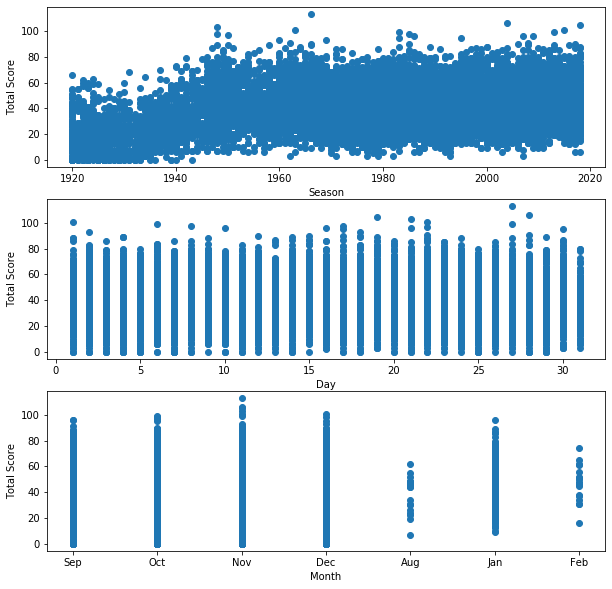

Number of games in Aug: 22
Number of games in Dec: 3591
Number of games in Feb: 17
Number of games in Jan: 552
Number of games in Nov: 4521
Number of games in Oct: 4462
Number of games in Sep: 3109


In [117]:
# Plot Season, Month, and Day vs. Total Score
f, axs = plt.subplots(3,1,figsize=(10,10))
plt.subplot(311)
plt.xlabel("Season")
plt.ylabel("Total Score")
plt.scatter(games.season, games.totalScore)
plt.subplot(312)
plt.xlabel("Day")
plt.ylabel("Total Score")
plt.scatter(games.day, games.totalScore)
plt.subplot(313)
plt.xlabel("Month")
plt.ylabel("Total Score")
plt.scatter(games.month, games.totalScore)
plt.show()

# Print the number of games played in each month
for i in np.unique(games["month"].values):
    print("Number of games in %s: %d" % (i, (games.month == i).sum()))

**Conclusions:**
- Total score for games seems to increase as the season increases, so season may be a valuable attribute.
- Day has no correlation on score, and is therefore not useful.
- August and Feburary appeared to have different scores than the other months, but their sample sizes (22 and 17, respectively) are too small to indicate any pattern. Also, the other months did not follow any pattern, so month is not useful. 

### 2. Neutral and Playoff Game Frequency

In [118]:
# Calculate percentage of games that are neutral/playoff games
neutralGames = (games.neutral == 1).sum()
playoffGames = (games.playoff == 1).sum()
totalGames = games.shape[0]
print("Neutral Game Percentage = %d/%d = %6.6f%%" %
      (neutralGames, totalGames, neutralGames/totalGames * 100))
print("Playoff Game Percentage = %d/%d = %6.6f%%" %
      (playoffGames, totalGames, playoffGames/totalGames * 100))

Neutral Game Percentage = 85/16274 = 0.522306%
Playoff Game Percentage = 566/16274 = 3.477940%


**Conclusions:**
- There are too few neutral site games for them to be useful.
- There is also not very many playoff games, but there is enough for me to believe it could be useful in my model. 

### 3. Team Points Per Game (PPG)

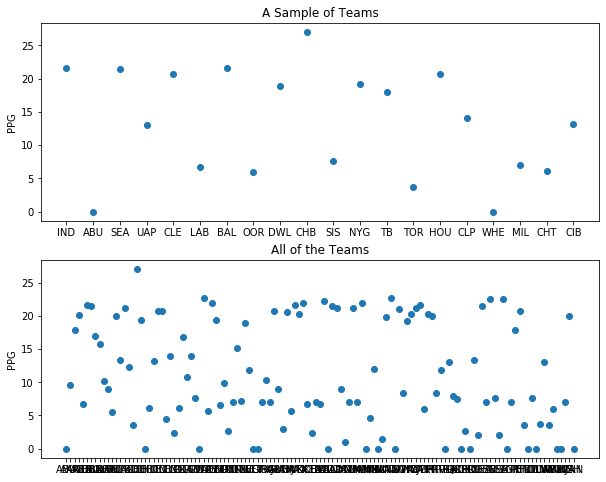

In [119]:
# Calculate the historical points per game for each team 
ppg = []
for i in np.unique(games[['team1', 'team2']].values):
    # find all instances of score1 when i == team1
    i1 = games.loc[games['team1'] == i].score1
    # find all instances of score2 when i == team2
    i2 = games.loc[games['team2'] == i].score2
    ppg.append(
        (i1.sum() + i2.sum()) / (i1.shape[0] + i2.shape[0])
    )

# Create a DataFrame for a team's ppg
ppgDf = pd.DataFrame({'team': np.unique(games[['team1', 'team2']].values), 'ppg': ppg})
ppgDfSample = ppgDf.sample(20)

# Plot team name vs. ppg
f, axs = plt.subplots(2,1,figsize=(10,8))
plt.subplot(211)
plt.title("A Sample of Teams")
plt.ylabel("PPG")
plt.scatter(ppgDfSample.team, ppgDfSample.ppg)
plt.subplot(212)
plt.title("All of the Teams")
plt.ylabel("PPG")
plt.scatter(ppgDf.team, ppgDf.ppg)
plt.show()

**Conclusion:** points scored per game depends on the team, which means that combining team and PPG as attributes in our data set should improve our model.

## Feature Engineering
_____________

Improve data set based on the exploratory data analysis.

### 1. Remove Post-Game Information
Remove the totalScore and result1 columns because we cannot use post-game stats for pregame score predictions.

In [120]:
del games["totalScore"]
del games["result1"]

### 2. Remove Date information
- Remove day column since it was determined it is not useful.
- Remove month column since it was determined it is not useful.
- Remove date column since the year, which is the only useful part of the date, is tracked in the season column.

In [121]:
del games["day"]
del games["month"]
del games["date"]

### 3. Game Type
- Remove the neutral column to avoid the few neutral games skewing our models.
- Keep the playoff column because there are a fair amount of playoff games.

In [122]:
del games["neutral"]

### 4. Add PPG
Add points per game for each team to the DataFrame since it should help predict a team's score.

In [123]:
# Add ppg for team1

# Merge the ppgDf (team, ppg) into the games DataFrame
games = games.merge(ppgDf, how='inner', left_on='team1', right_on='team')
# Delete the redundant team column
del games["team"]
# Rename ppg column to ppg1, to signify it's team1's ppg
games.rename(columns={"ppg": "ppg1"}, inplace=True)

# Add ppg for team2

# Merge the ppgDf (team, ppg) into the games DataFrame
games = games.merge(ppgDf, how='inner', left_on='team2', right_on='team')
# Delete the redundant team column
del games["team"]
# Rename ppg column to ppg2, to signify it's team2's ppg
games.rename(columns={"ppg": "ppg2"}, inplace=True)

games.sample(3)

,season,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,ppg1,ppg2
6330,2011,0,LAR,PHI,1416.520,1551.734,0.400307,13,31,21.469115,20.246166
4893,1949,0,WSH,PIT,1463.661,1459.556,0.598159,27,14,19.912698,19.932746
15350,2010,0,PIT,CAR,1609.796,1345.662,0.869285,27,3,19.932746,21.189526


### 5. One-Hot Encode the Teams
Team name is valuable since different teams have varying PPG. Since the team attribute is discrete, we will one-hot encode it.

In [124]:
# One-hot encode the two teams
games = pd.get_dummies(
    games,
    columns=['team1', 'team2'],
    sparse=True
)

games.sample(3)

,season,playoff,elo1,elo2,elo_prob1,score1,score2,ppg1,ppg2,team1_AKR,team1_ARI,team1_ATL,team1_BAL,team1_BBA,team1_BCL,team1_BDA,team1_BFF,team1_BKN,team1_BRL,team1_BUF,team1_BYK,team1_CAR,team1_CBD,team1_CHB,team1_CHI,team1_CHL,team1_CHT,team1_CIB,team1_CIN,team1_CLE,team1_CLI,team1_COL,team1_CRA,team1_CRP,team1_CST,team1_CTI,team1_DAL,team1_DAY,team1_DEN,team1_DET,team1_DHR,team1_DPN,team1_DTI,team1_DTX,team1_DUL,team1_DWL,team1_ECG,team1_ELY,team1_FTW,team1_FYJ,team1_GAR,team1_GB,team1_GUN,team1_HAM,team1_HOU,team1_HRT,team1_IND,team1_JAX,team1_KC,team1_KCB,team1_KEN,team1_LAC,team1_LAR,team1_LDA,team1_LOG,team1_LOU,team1_MIA,team1_MIL,team1_MIN,team1_MNM,team1_MNN,team1_MSA,team1_MUN,team1_NAA,team1_NE,team1_NG1,team1_NO,team1_NYA,team1_NYG,team1_NYJ,team1_NYY,team1_OAK,team1_OOR,team1_PHI,team1_PIT,team1_PRV,team1_PTB,team1_PUL,team1_RAC,team1_RCH,team1_RCK,team1_RED,team1_RIC,team1_RII,team1_ROS,team1_SEA,team1_SEN,team1_SF,team1_SIS,team1_SLA,team1_STG,team1_TB,team1_TEN,team1_THO,team1_TOL,team1_TOR,team1_UAP,team1_WGC,team1_WSH,team1_ZAN,team2_ABU,team2_AKR,team2_ARI,team2_ATL,team2_ATN,team2_BAL,team2_BBA,team2_BCL,team2_BDA,team2_BFF,team2_BKN,team2_BRL,team2_BUF,team2_BYK,team2_CAR,team2_CBD,team2_CCL,team2_CHI,team2_CHT,team2_CIB,team2_CIN,team2_CLE,team2_CLI,team2_CLP,team2_CNC,team2_COL,team2_CRA,team2_CRP,team2_CTI,team2_CWP,team2_DAL,team2_DAY,team2_DEN,team2_DET,team2_DHR,team2_DPN,team2_DTI,team2_DTM,team2_DTX,team2_DUL,team2_DWL,team2_ECG,team2_FTP,team2_FYJ,team2_GB,team2_GUN,team2_HAM,team2_HOU,team2_HRT,team2_IND,team2_JAX,team2_KC,team2_KCB,team2_KEN,team2_KEW,team2_LAB,team2_LAC,team2_LAN,team2_LAR,team2_LDA,team2_LOU,team2_MCK,team2_MIA,team2_MIL,team2_MIN,team2_MNN,team2_MSA,team2_MUN,team2_MUT,team2_NAA,team2_NE,team2_NG1,team2_NO,team2_NYA,team2_NYG,team2_NYJ,team2_NYY,team2_OAK,team2_OOR,team2_PHI,team2_PIT,team2_PRV,team2_PTB,team2_PTQ,team2_RAC,team2_RCH,team2_RED,team2_RII,team2_ROS,team2_SEA,team2_SF,team2_SIS,team2_SLA,team2_STG,team2_STP,team2_SYR,team2_TB,team2_TEN,team2_THO,team2_TLM,team2_TOL,team2_TON,team2_TOR,team2_UTI,team2_WBU,team2_WHE,team2_WJA,team2_WSH
12419,1986,0,1377.67000,1535.646000,0.369302,7,26,21.640428,20.212973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14242,1967,0,1493.49400,1595.912000,0.446358,10,33,22.705329,21.894510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8800,2015,0,1681.26907,1543.273584,0.762880,23,20,17.798817,21.888770,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Regression Models
_________________________

#### We will be using R^2, the coefficient of determination, to evaluate the accuracy of our models. Perfect accuracy would result in an R^2 value of 1.

- Split the DataFrame into features and target values, as well as training and testing subsets.
- Create a function that will fit the regressor and print its training and testing R^2 values. 

In [140]:
# Split the DataFrame into features and target values
features = [i for i in games.columns.tolist() if (i != "score1" and i != "score2")]
target = ["score1", "score2"]
X = games[features]
y = games[target]

# Split the data set into 80% training data and 20% test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# Use the given regressor to fit the training and testing data, and then print the R^2 values.
def fitAndPrint(reg):
    reg = reg.fit(X_train, y_train)
    print("-Training R^2: %4.4f" %
          r2_score(y_train, reg.predict(X_train), multioutput='variance_weighted'))
    print("-Testing R^2: %4.4f" %
          r2_score(y_test, reg.predict(X_test), multioutput='variance_weighted'))

### 1. Decision Tree

In [141]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

dt = DecisionTreeRegressor(random_state=0)
print("Decision Tree Regressor:")
fitAndPrint(dt)

Decision Tree Regressor:
-Training R^2: 1.0000
-Testing R^2: -0.6046


**Conclusions:**
- Using a decision tree leads to extreme overfitting, as shown by the training R^2 of 1.00.
- The decision tree does not follow the trend of the data, as shown by the negative testing R^2 value.
- This does not accurately predict scores.

### 2. Random Forrests
Evaluate the R^2 values of multiple random forrest regressors that vary by the number of trees in the forrest.

In [143]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=0)
print("Random Forest Regressor With 10 Trees:")
fitAndPrint(rf)

for i in range (50, 251, 50):
    rf = RandomForestRegressor(n_estimators=i, random_state=0)
    print("\nRandom Forest Regressor With %d Trees:" % i)
    fitAndPrint(rf)

Random Forest Regressor With 10 Trees:
-Training R^2: 0.8333
-Testing R^2: 0.0679

Random Forest Regressor With 50 Trees:
-Training R^2: 0.8742
-Testing R^2: 0.1243

Random Forest Regressor With 100 Trees:
-Training R^2: 0.8792
-Testing R^2: 0.1331

Random Forest Regressor With 150 Trees:
-Training R^2: 0.8811
-Testing R^2: 0.1355

Random Forest Regressor With 200 Trees:
-Training R^2: 0.8820
-Testing R^2: 0.1391

Random Forest Regressor With 250 Trees:
-Training R^2: 0.8824
-Testing R^2: 0.1399


**Conclusions:**
- Random forrests still have overfitting, as shown by the high training R^2 for each model.
- The Accuracy improvement levels off around 100 trees.
 - We can save computational resources by using the 100 tree regressor because it provides a similiar accuracy to the regressors with more trees
- This is still has low accuracy, but is a huge improvement from the decision tree.

### 3. Multi-Layer Perceptron
MLPs are feedforward artificial neural networks. Evaluate its testing and training R^2 values.

In [144]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor()
print("Multi-Layer Perceptron Regressor:")
fitAndPrint(mlp)

Multi-Layer Perceptron Regressor:
-Training R^2: 0.1509
-Testing R^2: 0.1441


**Conclusions:**
- This MLP does not suffer from overfitting like the decison tree and random forrests do because its training and testing R^2 values are the same.
- The R^2 is slightly better than the random forrest.
- This is the best score predictor so far.

### 4. Gradient Boosting
sklearn's gradient boosting regressor only works for one target variable, so I wrap it in a MultiOutputRegressor which fits the features to each target variable seperately. Then, we can use it to predict multi-output variables.

In [145]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

gb = MultiOutputRegressor(GradientBoostingRegressor())
print("Gradient Boosting Regressor:")
fitAndPrint(gb)

Gradient Boosting Regressor:
-Training R^2: 0.2238
-Testing R^2: 0.1794


**Conclusions:**
- This gradient boosting regressor also does not suffer from overfitting.
- The R^2 is even better than the MLP.
- This is the best score predictor, despite its R^2 value still being low.

## Conclusions
_________________

#### 1. Tree based regression models have problems with overfitting.
#### 2. Trying to predict scores of NFL games when we are given few statistics/features leads to poor R^2 values. 